In [1]:
%%capture
%%shell
git clone https://github.com/plarotta/vision-encoder.git
mv /content/vision-encoder/transfer_learner/ /content/
rm -rf /content/vision-encoder/
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zxFDf6wqacM4EfMzLp2YD7kI9g-3KtJk' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zxFDf6wqacM4EfMzLp2YD7kI9g-3KtJk" -O UR5_images_2.zip && rm -rf /tmp/cookies.txt
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TAMiAfoJIyFmvGo5gLzxftRHprF60PzG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TAMiAfoJIyFmvGo5gLzxftRHprF60PzG" -O UR5_positions_2.csv && rm -rf /tmp/cookies.txt
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M16MVlj7pFdaw_JB0iwEe2xFlmeBhgkY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1M16MVlj7pFdaw_JB0iwEe2xFlmeBhgkY" -O UR5_images_3.zip && rm -rf /tmp/cookies.txt
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CDgE1eaYw0R-PdWPWFRXKWpowmSN7pMh' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CDgE1eaYw0R-PdWPWFRXKWpowmSN7pMh" -O UR5_positions_3.csv && rm -rf /tmp/cookies.txt
unzip UR5_images_3.zip
mv UR5_images_3/ images/
rm UR5_images_3.zip
pip install wandb -qq

In [2]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
from skimage import io
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transfer_learner.source.model import RobotNet
from transfer_learner.source.robot_dataset import RobotImageDataset
from transfer_learner.utils.trainers import train_one_epoch, validate_one_epoch
import wandb

In [24]:
class RobotImageDataset(Dataset):
    #TODO: make multi_input = False functional. Right now it fails
    def __init__(self, csv_file: str, root_dir: str, multi_input = False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[['ImageID','Joint3','Joint4','Joint5', 'Joint6']]
        self.root_dir = root_dir
        self.multi_input = multi_input
        self.file_names = ["side_view_",
                           "front_view_",
                           "top_view_",
                           "corner1_view_",
                           "corner2_view_",
                           "side_depth_view_",
                           "front_depth_view_",
                           "top_depth_view_",
                           "corner1_depth_view_",
                           "corner2_depth_view_"]

        #TODO: improve transform so that the final image view is more zoomed in

        if self.multi_input:
            self.transform = v2.Compose(
                [
                    v2.ToDtype(torch.float32),
                    v2.ToTensor(),
                    v2.Resize(size=(224, 224), antialias=True),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], #default resnet norm
                                std=[0.229, 0.224, 0.225]),
                    v2.ToTensor()
                ])
        else:
            self.transform = v2.Compose(
                [
                    v2.ToDtype(torch.float32),
                    v2.ToTensor(),
                    v2.Resize(size=(224, 224), antialias=True),
                    v2.Grayscale(),
                    v2.ToTensor()
                ])

    def process_images(self, images):
        for im_idx in range(len(images)):
            if len(images[im_idx].shape) > 2:
                images[im_idx] = images[im_idx][:,:,:3]
            images[im_idx] = self.transform(images[im_idx])
        out = [im for im in images] if self.multi_input else torch.cat([im for im in images],dim = 0)
        return(out)

    def __len__(self):
        return(len(self.annotations))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = [io.imread(os.path.join(self.root_dir, f + str(idx) + '.png')) for f in self.file_names]
        im_data = self.process_images(images)
        joint_values = self.annotations.iloc[idx, 1:].to_numpy(dtype=float)
        sample = {'images': im_data, 'joint_values': joint_values}
        return sample

In [25]:
robotdata = RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', multi_input=False)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
print(robotdata[0]['images'].shape)
plt.imshow(robotdata[0]['images'][0])

In [49]:
# RUN THIS MODEL!!!
class RobotNet(nn.Module):
    def __init__(self, n_hidden_units1, n_hidden_units2, n_inputs=1, freeze_resnet = False):
        super().__init__()
        self.num_inputs = n_inputs
        self.in_dim1 = n_hidden_units1
        self.in_dim2 = n_hidden_units2
        self.weights = ResNet18_Weights.DEFAULT

        self.base_model = resnet18(weights=self.weights)
        self.base_layers = list(self.base_model.children())

        # freeze resnet layers
        if freeze_resnet:
            for idx,child in enumerate(self.base_layers):
              for param in child.parameters():
                param.requires_grad = False


        self.resnet_layers = nn.Sequential(
            *self.base_layers[:-1])

        self.linear_output = nn.Sequential(
            nn.Linear(in_features=512*self.num_inputs, out_features=self.in_dim1),
            nn.ReLU(),
            nn.Linear(in_features=self.in_dim1, out_features=self.in_dim2),
            nn.ReLU(),
            nn.Linear(in_features=self.in_dim2, out_features=4)
        )


    def forward(self, inputs):
        # pseudo hard coded way of giving multi-input option
        # x1 = self.resnet_layers(x1)
        # if self.num_inputs == 2:
        #     x2 = self.resnet_layers(x2)
        #     out = self.linear_output(torch.cat([x1,x2],dim=1).view(-1,512*self.num_inputs))
        # elif self.num_inputs == 3:
        #     x2 = self.resnet_layers(x2)
        #     x3 = self.resnet_layers(x3)
        #     out = self.linear_output(torch.cat([x1,x2,x3],dim=1).view(-1,512*self.num_inputs))
        #     del x1
        #     del x2
        #     del x3
        # else:
        #     out = self.linear_output(x1.view(-1,512*self.num_inputs))
        #     del x1

        for idx in range(len(inputs)):
            #run all inputs through resnet
            inputs[idx] = self.resnet_layers(inputs[idx])

        out = self.linear_output(torch.cat(inputs,dim=1).view(-1,512*len(inputs)))

        return out

In [50]:
robotdata = RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', multi_input=False)


def train_one_epoch(tr_loader, model, loss_func, optimizer, device,feedback=None):
    running_loss = 0.0
    fback = 0.0

    for i, data in enumerate(tr_loader):
        im1 = data['images']
        y = data['joint_values'].float()
        im1,y = im1.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(im1).float()
        preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
        y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
        loss = loss_func(preds_hat, y_hat)

        running_loss +=loss.item()
        loss.backward()
        optimizer.step()
        if feedback:
            fback += feedback(preds,y).item()


    train_loss = running_loss/(i+1)
    if feedback:
        return(train_loss,fback/(i+1))
    else:
      return(train_loss)

def validate_one_epoch(val_loader, model, loss_func, optimizer, device,feedback=None):
    running_loss = 0.0
    fback = 0.0

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            im1 = data['images']
            y = data['joint_values'].float()
            im1, y = im1.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(im1).float()
            preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
            y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
            loss = loss_func(preds_hat, y_hat)
            running_loss +=loss.item()
            if feedback:
                fback += feedback(preds,y)
    val_loss = running_loss/(i+1)

    if feedback:
        return(val_loss,fback/(i+1))
    else:
      return(val_loss)

def main():
    run = wandb.init(project='vision-encoder')
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 32
    EPOCH = 75
    IN_DIM1 = 128
    IN_DIM2 = 32


    # Check if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Params
    traindata, validdata = random_split(robotdata, [0.8,0.2])
    trainloader = DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    validloader = DataLoader(validdata, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    multi_model = RobotNet(IN_DIM1, IN_DIM2,n_inputs=1)


    # Initialize
    multi_model.to(device)
    criterion = nn.MSELoss()
    feedback = nn.MSELoss()
    optimizer = optim.AdamW(multi_model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= 1000)

    for epoch in range(1,EPOCH):

        tr_loss,t_fback = train_one_epoch(trainloader, multi_model, criterion, optimizer, device, feedback)
        val_loss,v_fback = validate_one_epoch(validloader, multi_model, criterion, optimizer, device, feedback)
        wandb.log(
            {
                "epoch": epoch,
                "train_loss": tr_loss,
                "val_loss": val_loss,
                "train_feedback": t_fback,
                "val_feedback": v_fback
            }
        )
        print(f'epoch: {epoch} | train loss: {tr_loss} | val loss: {val_loss} | "train_feedback": {t_fback} | "val_feedback": {v_fback}')
        scheduler.step()
        torch.save(multi_model.state_dict(),os.path.join(wandb.run.dir, f"model_state_dict_epoch{epoch}.pth"))
    run.finish()
    torch.save(multi_model.state_dict(), 'model_state.pth')

main()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


cuda:0


RuntimeError: ignored

In [ ]:
robotdata = RobotImageDataset('/content/UR5_positions_2.csv', '/content/images', multi_input=False)
netty = RobotNet(128,32)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.3MB/s]


In [ ]:
netty.load_state_dict(torch.load("/content/model_state_dict_epoch74.pth",map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[ 2.25134251  0.8404059  -1.23456089  1.91287764]')

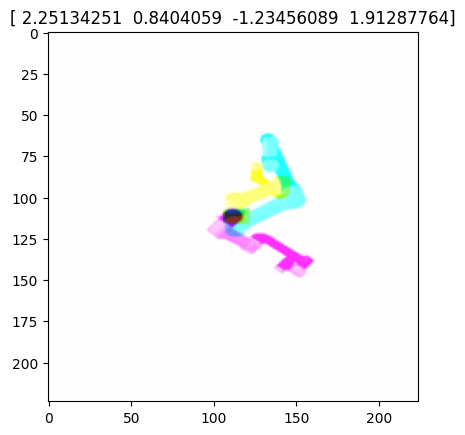

In [ ]:
plt.imshow(robotdata[0]['images'].transpose(0,2))
plt.title(robotdata[0]['joint_values'])

In [ ]:
print(robotdata[1]['joint_values'],netty(robotdata[1]['images'].unsqueeze(0)))

[-2.20821107 -0.54609864 -1.57010996 -0.74045576] tensor([[-1.7552, -0.0924,  1.2814, -1.2973]], grad_fn=<AddmmBackward0>)


In [6]:
np.sin([-2.20821107, -0.54609864, -1.57010996, -0.74045576])

array([-0.80363698, -0.51935725, -0.99999976, -0.67462441])

In [7]:
np.sin([-1.7552, -0.0924,  1.2814, -1.2973])

array([-0.98304577, -0.09226857,  0.95841632, -0.96283243])